In [39]:
import logging
import sys
import os
%cd ..
from bds.meel import approx_mc2, approx_mc2_core
from bds.rule import Rule
from bds.utils import bin_random , bin_array, randints, solutions_to_dict

#from bds.bb import BranchAndBoundNaive, BranchAndBoundV1, BranchAndBoundV0, BranchAndBoundV2
from logzero import logger
import gmpy2 as gmp
from gmpy2 import mpz , mpfr
from bds.sat.min_freq import construct_min_freq_program
from bds.sat.solver import construct_solver
from bds.gf2 import GF
from bds.rule import Rule
from bds.utils import mpz_set_bits
from tests.utils import assert_dict_allclose, assert_close_mpfr

#from bds.bounds_utils import find_equivalence_classes
import numpy as np 

from bds.cbb_v2 import * 
from bds.cbb_v2 import (
    ConstrainedBranchAndBound,
    count_added_pivots,
    ensure_no_violation,
    ensure_satisfiability,
)

logger.setLevel(logging.DEBUG)

num_pts = 500

show_progres = True
rand_seed = 1234

/u/50/ciaperm1/unix


In [40]:
# Load the CSV file using Pandas
import pandas as pd
df = pd.read_csv('data/sqf-2016.csv')


FileNotFoundError: [Errno 2] No such file or directory: 'data/sqf-2016.csv'

In [ ]:
toexcl = ['riflshot',
 'asltweap',
 'knifcuti',
 'machgun',
 'othrweap',
 'pf_hands',
 'pf_wall',
 'pf_grnd',
 'pf_drwep',
 'pf_ptwep',
 'pf_baton',
 'pf_hcuff',
 'pf_pepsp',
 'pf_other',
 'radio',
 'ac_rept',
 'ac_inves',
 'rf_vcrim',
 'rf_othsw',
 'ac_proxm',
 'rf_attir',
 'cs_objcs',
 'cs_descr',
 'cs_casng',
 'cs_lkout',
 'rf_vcact',
 'cs_cloth',
 'cs_drgtr',
 'ac_evasv',
 'ac_assoc',
 'cs_furtv',
 'rf_rfcmp',
 'ac_cgdir',
 'rf_verbl',
 'cs_vcrim',
 'cs_bulge',
 'cs_other',
 'ac_incid',
 'ac_time',
 'rf_knowl',
 'ac_stsnd',
 'ac_other',
 'sb_hdobj',
 'sb_outln',
 'sb_admis',
 'sb_other',
 'rf_furt',
 'rf_bulg',
 'offverb',
 'offshld',
 'dettypCM',
 'lineCM']

In [ ]:
to_keep = [] 
for col in df.columns: 
    
    if col == "pistol": 
        y = np.array(df[col])
        continue 
        

    
    if col!="year" and col not in toexcl:
        l = len(df[col].unique())
        if l <= 3 and l>1 : 
            to_keep.append(col) 

In [41]:
to_keep

['recstat',
 'inout',
 'explnstp',
 'othpers',
 'arstmade',
 'sumissue',
 'compyear',
 'comppct',
 'offunif',
 'officrid',
 'frisked',
 'searched',
 'contrabn',
 'adtlrept']

In [42]:
df2 = df[to_keep] 
df_categorical = df2.select_dtypes(include='object')  # Select columns of type 'object' (categorical)
df_encoded = pd.get_dummies(df_categorical)

In [43]:
df_encoded.shape

(12405, 40)

In [44]:
y.shape

(500,)

In [45]:
from bds.fpgrowth import preprocess_transaction_list, build_fptree, fpgrowth_on_tree

In [46]:
X = df_encoded.to_numpy().astype(bool)

In [47]:
np.unique(y)
new = [] 
for x in y: 
    
    if x =="N": 
        new.append(0) 
    else: 
        new.append(1) 
        
y = np.array(new).astype(bool)

In [48]:
lmbd = 0.1
min_support = 450

# now we need to extract rules 
X_bag = [set([j for j, x in enumerate(row) if x]) for row in X]

ordered_input_data = preprocess_transaction_list(
    X_bag, min_support
)
tree = build_fptree(ordered_input_data)
frequent_itemsets = set(fpgrowth_on_tree(tree, set(), min_support))

In [49]:
from bds.rule import Rule
from time import time

def compute_truthtable(X,itemset): 
    ''' poorly optimized function '''
    support_list = [] 
    for i in range(X.shape[0]): 
        if sum([X[i][j] for j in itemset]) == len(itemset): 
            support_list.append(i)
                
    truthtable = mpz_set_bits(mpz(), support_list)
    
    return truthtable

In [ ]:
# Now create rules 
rules = [] 
for i,itemset in enumerate(frequent_itemsets):
    tt = compute_truthtable(X,itemset)
    this_Rule = Rule(id = i+1, name = "rule_" + str(i), cardinality=len(itemset), truthtable=tt)
    # we need the truthtable for this itemset 
    rules.append(this_Rule) 
    

In [ ]:
len(rules)

In [ ]:
import pickle 
pickle.dump(rules, open("rules_NYPD_" + str(len(rules)), "wb" ))

In [19]:
from bds.cbb_v2 import (
    ConstrainedBranchAndBound,
    count_added_pivots,
    ensure_no_violation,
    ensure_satisfiability,
)

In [20]:
lmbd = 0.1
ub = 0.4 
cbb = ConstrainedBranchAndBoundNaive(rules, ub, y, lmbd)
cbb_v2 = ConstrainedBranchAndBound(rules, ub, y, lmbd)

[D 230620 20:23:03 bb:53] calling ConstrainedBranchAndBoundNaive with ub=0.4, lmbd=0.1
[D 230620 20:23:03 bb:53] calling ConstrainedBranchAndBound with ub=0.4, lmbd=0.1


In [21]:
import time 

In [36]:
ordered_input_data = preprocess_transaction_list(
    X_bag, min_support
)
tree = build_fptree(ordered_input_data)

all_times_naive = [] 
all_times = [] 
all_times_approx_mc2= []

eps = 0.125
delta = 0.125

for min_support in [350, 400, 450]:  
    
    
    #print("min support " + str(min_support)) 
    #print("tree " + str(tree))

    frequent_itemsets = set(fpgrowth_on_tree(tree, set(), min_support))
    # Now create rules 
    rules = [] 
    for i,itemset in enumerate(frequent_itemsets):
        tt = compute_truthtable(X,itemset)
        this_Rule = Rule(id = i+1, name = "rule_" + str(i), cardinality=len(itemset), truthtable=tt)
        # we need the truthtable for this itemset 
        rules.append(this_Rule) 
    
    #    
    #
    
    print(len(rules))
    
    pickle.dump(rules, open("rules_NYPD_" + str(len(rules)), "wb" ))

    lmbd = 0.1
    ub = 0.5
    cbb = ConstrainedBranchAndBoundNaive(rules, ub, y, lmbd)
    cbb_v2 = ConstrainedBranchAndBound(rules, ub, y, lmbd)
    
    #
    #
    
    rand_seed = 12
    num_constraints = 5
    num_rules = len(rules)
    
    from bds.random_hash import generate_h_and_alpha
    A, t = generate_h_and_alpha(
    num_rules, num_constraints, rand_seed, as_numpy=True
    )
    
    start_time = time.time() 
    actual_sols = solutions_to_dict(
    list(cbb_v2.run(return_objective=True, A=A, t=t)))
    all_times.append(time.time() - start_time)
    
    
    start_time = time.time() 
    actual_sols = solutions_to_dict(
    list(cbb.run(return_objective=True, A=A, t=t)))
    all_times_naive.append(time.time() - start_time)
    
    
    thresh = 72
    prev_m = 1
    start_time = time.time() 
    est = approx_mc2( rules =  rules,
    y=y,
    lmbd = lmbd,
    ub = ub,
    delta =delta,
    eps =  eps)
    all_times_approx_mc2.append(time.time() - start_time)

[D 230620 20:27:13 bb:53] calling ConstrainedBranchAndBoundNaive with ub=0.5, lmbd=0.1
[D 230620 20:27:13 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230620 20:27:13 cbb:160] setting up the parity constraint system
[D 230620 20:27:13 cbb:129] simplifying A x = t using rref
[D 230620 20:27:13 cbb:136] density(A_rref) = 47.717% (from 54.0%)
[D 230620 20:27:13 cbb:160] setting up the parity constraint system
[D 230620 20:27:13 cbb:129] simplifying A x = t using rref
[D 230620 20:27:13 cbb:136] density(A_rref) = 47.717% (from 54.0%)
[D 230620 20:27:13 meel:358] calling approx_mc2 with eps = 0.12 and delta=0.12
[D 230620 20:27:13 meel:361] thresh = 886.60
[D 230620 20:27:13 bb:53] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1
[D 230620 20:27:13 meel:372] BB solving (thresh=886) takes 0.00 secs
    and gave 0 solutions
[D 230620 20:27:13 meel:377] exit since number of solutions 0 < 886
[D 230620 20:27:13 bb:53] calling ConstrainedBranchAndBoundNaive with ub=0.5, lmb

127
127


[D 230620 20:27:13 bb:53] calling ConstrainedBranchAndBoundNaive with ub=0.5, lmbd=0.1
[D 230620 20:27:13 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230620 20:27:13 cbb:160] setting up the parity constraint system
[D 230620 20:27:13 cbb:129] simplifying A x = t using rref
[D 230620 20:27:13 cbb:136] density(A_rref) = 48.350% (from 53.2%)
[D 230620 20:27:13 cbb:160] setting up the parity constraint system
[D 230620 20:27:13 cbb:129] simplifying A x = t using rref
[D 230620 20:27:13 cbb:136] density(A_rref) = 48.350% (from 53.2%)
[D 230620 20:27:13 meel:358] calling approx_mc2 with eps = 0.12 and delta=0.12
[D 230620 20:27:13 meel:361] thresh = 886.60
[D 230620 20:27:13 bb:53] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1
[D 230620 20:27:13 meel:372] BB solving (thresh=886) takes 0.00 secs
    and gave 0 solutions
[D 230620 20:27:13 meel:377] exit since number of solutions 0 < 886


103


In [37]:
all_times_approx_mc2

[0.0034508705139160156, 0.0034492015838623047, 0.003145456314086914]

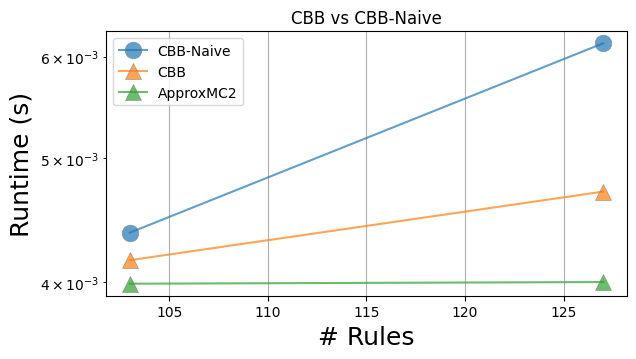

In [29]:
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(1, 1, figsize=(6.38, 3.7))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

all_n_rules = [127, 103]

plt.plot(all_n_rules, all_times_naive[1:], label="CBB-Naive", marker = "o", linewidth=1.5 , color = colors[0],  markersize = 12 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.7) 
plt.plot(all_n_rules, all_times[1:], label="CBB", marker = "^", linewidth=1.5 , color = colors[1],   markersize = 12 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.7) 
plt.plot(all_n_rules, all_times_approx_mc2[1:], label="ApproxMC2", marker = "^", linewidth=1.5 , color = colors[2],   markersize = 12 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.7) 

plt.title("CBB vs CBB-Naive") 
plt.xlabel("# Rules", fontsize = 18)
plt.ylabel("Runtime (s)", fontsize = 18)
plt.legend()
plt.grid()
plt.tight_layout() 
plt.yscale("log")
plt.savefig("plots/comparison_naive_and_v2_nypd_approx_mc_095" + ".pdf" )
plt.show()